# Assignment 02

In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from typing import Callable

In [3]:
pd.options.display.precision = 4

In [4]:
def cross_valid(df: pd.DataFrame, k):
    n = df.shape[0] // k
    for i in range(0, df.shape[0], n):
        test = df.iloc[i:i + n]
        trainer = df.drop(test.index)
        yield trainer.copy(), test.copy()

class iris_data:
    row_feat: list = ['sepal length', 'sepal width', 'petal length', 'petal width']
    columns: list = row_feat + ['class']

    def __init__(self, df, trainer, devlop, test):
        self._df: pd.DataFrame = df.copy()
        self.trainer: pd.DataFrame = trainer.copy()
        self.devlop: pd.DataFrame = devlop.copy()
        self.test: pd.DataFrame = test.copy()
        self.min = self.test[self.row_feat].min()
        self.max = self.test[self.row_feat].max()

    @classmethod
    def reader(cls, filename: str, splits = 5, trainer_devlop_split = 0.70):
        df = pd.read_csv(filename, header=None, names=cls.columns)
        randomise = df.sample(frac=1)
        for trainer, test in cross_valid(randomise, splits):
            devlop = trainer.sample(frac=1 - trainer_devlop_split)
            trainer = trainer.drop(devlop.index)

            yield cls(randomise, trainer, devlop, test)

    def post_norm(self):
        outcome = self.copy()
        for df in (outcome._df, outcome.trainer, outcome.devlop, outcome.test):
            df[outcome.row_feat] = (df[outcome.row_feat] - outcome.min) / (outcome.max - outcome.min) 

        return outcome           

    def norm(self, pointers: np.ndarray):
        return (pointers - self.min.to_numpy()) / (self.max.to_numpy() - self.min.to_numpy())        

    def copy(self):
        return iris_data(self._df, self.trainer, self.devlop, self.test)       

In [5]:
class knn:
    def __init__(self, data: iris_data, dist_calc: Callable[[np.ndarray, np.ndarray], float]):
        self.data: iris_data = data.copy()
        self.dist_calc = dist_calc
        self.prediction = pd.concat([self.data.trainer, self.data.devlop])

    def predictor(self, pointers: np.ndarray, k):
        return self._predictor_internal(self.prediction, pointers, k)

    def result_accuracy(self, k):
        pointers = self.data.test[self.data.row_feat].to_numpy()
        success = 0
        for i, pointers in enumerate(pointers):
            
            pred_data= self.predictor(pointers, k)
            real_data = self.data.test['class'].iloc[i]
            
            if pred_data== real_data:
                success += 1

        return success / pointers.shape[0]

    def local_accuracy(self, k):
        pointers = self.data.devlop[self.data.row_feat].to_numpy()
        success = 0
        for i, pointers in enumerate(pointers):
            
            pred_data= self._predictor_internal(self.data.trainer, pointers, k)
            real_data = self.data.devlop['class'].iloc[i]
            
            if pred_data == real_data:
                success += 1

        return success / pointers.shape[0]

    def _predictor_internal(self, data, pointers: np.ndarray, k):
        dist = data[self.data.row_feat].to_numpy()
        dist_transform = lambda x: self.dist_calc(x, pointers)
        dist = np.apply_along_axis(dist_transform, 1, dist)

        neighbors = data.assign(d=dist).nsmallest(k, 'd')
        return neighbors['class'].mode()[0]

In [6]:
def l2norm(p):
    return np.sqrt(np.sum(p ** 2))


def euclidean_dist(p1, p2):
    return l2norm(p1 - p2)


def cosine_dist(p1, p2):
    sim = np.dot(p1, p2) / (l2norm(p1) * l2norm(p2))
    return 1 - sim

In [7]:
datasets = list(iris_data.reader('iris.data', 5, 0.70))

print(f'Train Data       = {datasets[0].trainer.shape}')
print(f'Development Data = {datasets[0].devlop.shape}')
print(f'Test Data        = {datasets[0].test.shape}')

Train Data       = (84, 5)
Development Data = (36, 5)
Test Data        = (30, 5)


creating 3 models for distance calculation


In [8]:
all_models = {
    'euclidean': [],
    'normalized euclidean': [],
    'cosine similarity': [],
}
for data in datasets:
    all_models['euclidean'].append(knn(data, euclidean_dist))
    all_models['normalized euclidean'].append(knn(data.post_norm(), euclidean_dist))
    all_models['cosine similarity'].append(knn(data, cosine_dist))

In [9]:
hyper_params = [1, 3, 5, 7]

Values of k as 1,3,5,7



In [10]:
accuracy = pd.DataFrame(columns=all_models.keys(), index=hyper_params)
for mdl_name, models in all_models.items():
    for k in hyper_params:
        accuracies = [mdl.local_accuracy(k) for mdl in models]
        accuracy.at[k, mdl_name] = np.average(accuracies)

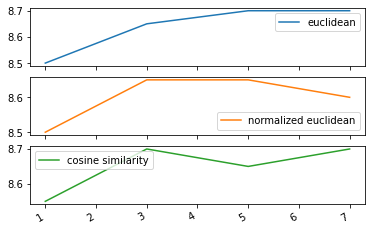

In [11]:
accuracy.plot(subplots = True)
plt.legend(loc=2)
plt.show()

In [12]:
accuracy

,euclidean,normalized euclidean,cosine similarity
1,8.5,8.5,8.55
3,8.65,8.65,8.7
5,8.7,8.65,8.65
7,8.7,8.6,8.7


Accuracy against test data.

In [13]:
result_accuracy = pd.DataFrame(columns=all_models.keys(), index=hyper_params)
for mdl_name, models in all_models.items():
    for k in hyper_params:
        accuracies = [mdl.result_accuracy(k) for mdl in models]
        result_accuracy.at[k, mdl_name] = np.average(accuracies)

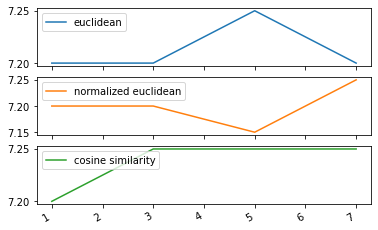

In [14]:
result_accuracy.plot(subplots = True)
plt.legend(loc=2)
plt.show()

In [15]:
result_accuracy

,euclidean,normalized euclidean,cosine similarity
1,7.2,7.2,7.2
3,7.2,7.2,7.25
5,7.25,7.15,7.25
7,7.2,7.25,7.25


Accuracy on test data.